In [1]:
import torch
import pandas as pd
import astropy as ap
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
# from astropy.io import fits
import pdb
from scipy.ndimage.filters import maximum_filter1d
import glob
import fitsio as fits
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.distributions.normal import Normal
from tqdm import tqdm

In [2]:
import sys
sys.path.insert(0, '../')
sys.path.insert(1, '../latent_ode/')
import latent_ode.lib as ode
import latent_ode.lib.utils as utils
from latent_ode.lib.latent_ode import LatentODE
from latent_ode.lib.encoder_decoder import Encoder_z0_ODE_RNN, Decoder
from latent_ode.lib.diffeq_solver import DiffeqSolver
from latent_ode.lib.ode_func import ODEFunc

In [3]:
from latent_rnn import create_LatentODE_model

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading

In [5]:
obsrv_std = torch.Tensor([0.01]).to(device)
z0_prior = Normal(torch.Tensor([0.0]).to(device), torch.Tensor([1.]).to(device))
input_dim = 1
model = create_LatentODE_model(input_dim, z0_prior, obsrv_std)

In [6]:
# state = torch.load('latent_ode_state.pth.tar')
state = torch.load('latent_ode_state.pth.tar', map_location=torch.device('cpu'))

In [7]:
model.load_state_dict(state['state_dict'])

<All keys matched successfully>

In [8]:
model.eval()

LatentODE(
  (encoder_z0): Encoder_z0_ODE_RNN(
    (GRU_update): GRU_unit(
      (update_gate): Sequential(
        (0): Linear(in_features=102, out_features=100, bias=True)
        (1): Tanh()
        (2): Linear(in_features=100, out_features=50, bias=True)
        (3): Sigmoid()
      )
      (reset_gate): Sequential(
        (0): Linear(in_features=102, out_features=100, bias=True)
        (1): Tanh()
        (2): Linear(in_features=100, out_features=50, bias=True)
        (3): Sigmoid()
      )
      (new_state_net): Sequential(
        (0): Linear(in_features=102, out_features=100, bias=True)
        (1): Tanh()
        (2): Linear(in_features=100, out_features=100, bias=True)
      )
    )
    (z0_diffeq_solver): DiffeqSolver(
      (ode_func): ODEFunc(
        (gradient_net): Sequential(
          (0): Linear(in_features=50, out_features=100, bias=True)
          (1): Tanh()
          (2): Linear(in_features=100, out_features=100, bias=True)
          (3): Tanh()
          (4): 

In [9]:
loader = torch.load('tess_train.pt')

## Inference

In [10]:
z_us = []
z_stds = []
truths = []
recs = []
for batch in tqdm(loader):
    observed = batch['observed_data']
    true = batch['data_to_predict']
    truths.append(true)
    mask = batch['observed_mask']
    mask_pred = batch['mask_predicted_data']
    mask_pred = torch.ones(mask.shape)
    x = torch.cat((observed, mask), -1)
    x2 = torch.cat((true, mask_pred), -1)
    t = batch['observed_tp']
    z_u, z_std = model.encoder_z0.forward(x, t)
    rec = model.get_reconstruction(time_steps_to_predict=t, truth=x, truth_time_steps=t)
    recs.append(rec)
#     z_u = z_u.squeeze()
#     z_u = z_u.detach().cpu().numpy()
    z_us.append(z_u)
    z_stds.append(z_std)

100%|██████████| 67/67 [00:40<00:00,  1.67it/s]


In [11]:
z_us = torch.cat(z_us)
z_stds = torch.cat(z_stds)
truths = torch.cat(truths)

In [12]:
z_us.shape

torch.Size([67, 1, 30])

In [13]:
ix = 1

In [14]:
u = z_us[ix]
std = z_stds[ix]

In [15]:
def sample(z, t):
    sol_y = model.diffeq_solver.sample_traj_from_prior(z, t, n_traj_samples = 1)
    out = model.decoder(sol_y)
    return out

In [16]:
t = batch['tp_to_predict']

In [17]:
out = sample(u.unsqueeze(0), t)

In [18]:
out = out.squeeze()

In [19]:
out.min()

tensor(0.8692, grad_fn=<MinBackward1>)

In [20]:
t = t.detach().cpu().numpy()
out = out.detach().cpu().numpy()

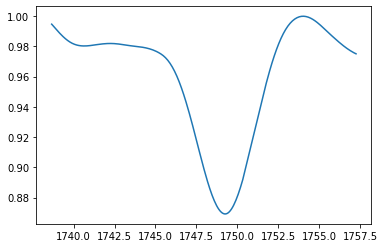

In [21]:
sns.lineplot(x=t, y=out)

In [39]:
ix=19

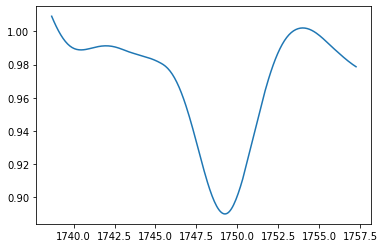

In [40]:
sns.lineplot(x=t, y=recs[ix][0].squeeze().detach().cpu().numpy())

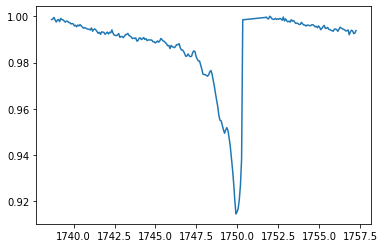

In [41]:
sns.lineplot(x=t, y=truths[ix].squeeze().detach().cpu().numpy())

### TSNE

In [42]:
from sklearn.manifold import TSNE

In [43]:
z_us.shape

torch.Size([67, 1, 30])

In [44]:
latents = z_us.squeeze().detach().cpu().numpy()

In [45]:
latents.shape

(67, 30)

In [105]:
tsne = TSNE(perplexity=10)

In [106]:
xx = tsne.fit_transform(latents)

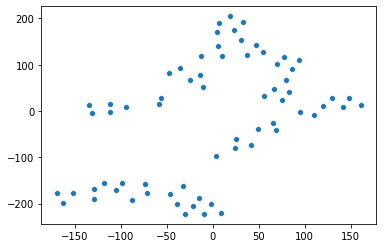

In [107]:
sns.scatterplot(x=xx[:,0], y=xx[:,1])

In [108]:
df = pd.DataFrame(xx, columns=['x1','x2'])
df['minimums'] = [np.round(x.min().item(),2) for x in truths]

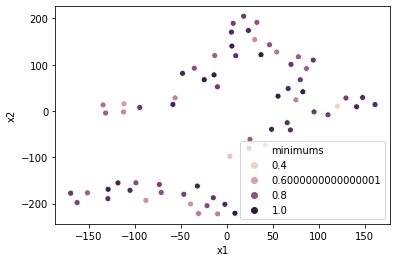

In [109]:
sns.scatterplot(x='x1', y='x2', data=df, hue='minimums')

In [114]:
g=df.loc[(df['x1']<-100) & (df['x2']<-100)]
g=df.loc[(df['x1']>0) & (df['x2']>100)]

In [115]:
gx = g.index

In [116]:
ls=truths[gx]

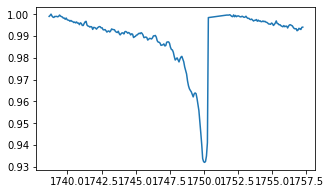

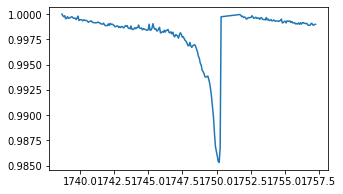

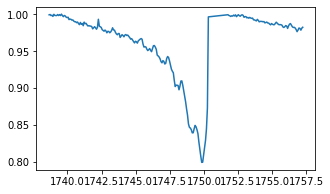

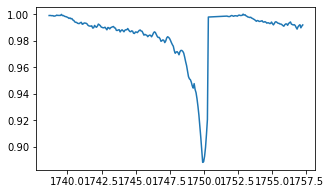

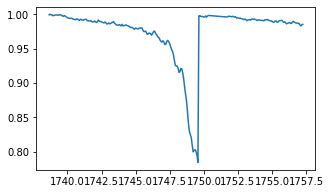

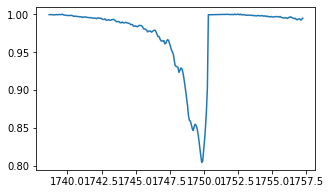

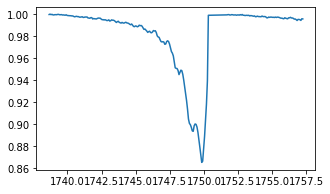

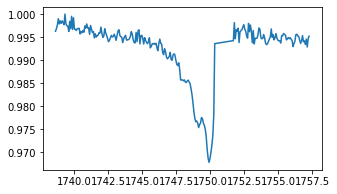

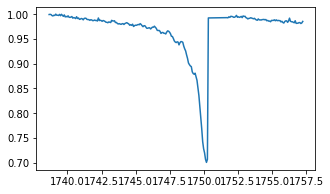

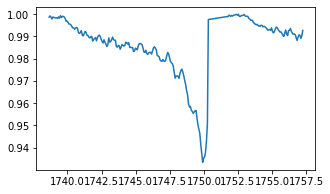

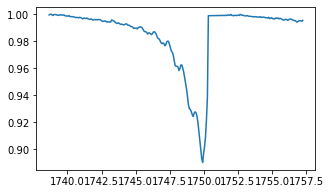

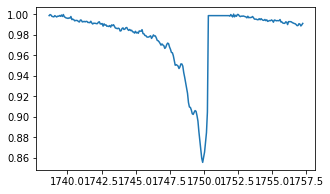

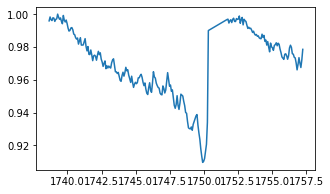

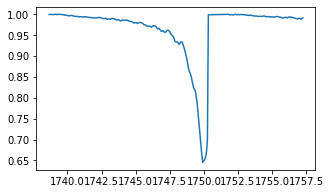

In [117]:
for p in ls:
    x = p.detach().cpu().squeeze().numpy()
    plt.figure(figsize=(5,3))
    sns.lineplot(x=t, y=x)
    plt.show()